# 一、多重共线性

$$w=(X^{T}X)^{-1}X^{T}y$$

特征矩阵不存在多重共线性↔矩阵的行列式不能为0↔矩阵满秩↔逆矩阵存在

## （一）概念

多重共线性（Multicollinearity）是一种统计现象，是指线性模型中的特征（解释变量）之间由于存在精确相关关系或高度相关关系，多重共线性的存在会使模型无法建立或者估计失真。多重共线性使用指标**方差膨胀因子**（variance inflationfactor，VIF）来进行衡量（from statsmodels.stats.outliers_influence import variance_inflation_factor）。<br>
相关性（Correlation）是衡量两个或多个变量一起波动的程度的指标，它可以是正的，负的或者0。当我们说变量之间具有相关性，通常是指**线性**相关性，线性相关一般由**皮尔逊相关系数**进行衡量，**非线性相关**可以使用**斯皮尔曼相关系数**或者**互信息法**进行衡量。

## （二）处理方法

### 1.使用统计学的先验思路

在开始建模之前先对数据进行各种相关性检验，如果存在多重共线性则可考虑对数据的特征进行**删减筛查**，或者使用**降维算法**对其进行处理，最终获得一个完全不存在相关性的数据集。

### 2.使用向前逐步回归

逐步归回能够筛选对标签**解释力度最强**的特征，同时对于存在相关性的特征们加上⼀个**惩罚项**，削弱其对标签的贡献，以**绕过最小二乘法**对共线性较为敏感的缺陷。

### 3.改进线性回归

在原有的线性回归算法基础上进行修改，使其能够容忍特征列存在多重共线性的情况，并且能够顺利建模，且尽可能的保证RSS取得最小值。

这三种手段中，第一种相对耗时耗力，需要较多的人工操作，并且会需要混合各种统计学中的知识和检验来进行使用。在机器学习中，能够使用一种模型解决的问题，尽量不用多个模型来解决，如果能够追求结果，我们会尽量避免进行一系列检验。第二种手段在现实中应用较多，不过由于理论复杂，效果也不是非常高效，因此向前逐步回归不是机器学习的首选。本次课程的核心是使用第三种方法：改进线性回归来处理多重共线性。为此，一系列算法岭回归、Lasso、弹性网就被研究出来了。

# 二、岭回归

## （一）岭回归解决多重共线性

在多元线性回归的损失函数上加上了正则项，表达为系数$w$的**L2范式**（即系数$w$的平方项）乘以正则化系数$α（α≠0）$：

$$min_w||Xw-y||_{2}^{2}+α||w||_2^2$$

$$w=(X^{T}X+αI)^{-1}X^{T}y$$

如果原本的矩阵$X^{T}X$中存在对角线上元素为$-α$，其他元素都为0的行或者列，就更换$α$取值。因此，矩阵的逆是永远存在的。$α$越大，模型越不容易受到共线性的影响。$α$挤占了$w$中由原始的特征矩阵贡献的空间，因此$α$如果太大，也会导致 $w$的估计出现较大的偏移，无法正确拟合数据的真实面貌，因此需要找出让模型效果变好的最佳取值。

## （二）linear_model.Ridge

`sklearn.linear_model.Ridge`(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

### 1.导入需要的模块和库

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_california_housing as fch
import matplotlib.pyplot as plt

### 2.导入数据

In [2]:
housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数","房屋使用年代中位数","平均房间数目","平均卧室数目","街区人口","平均入住率","街区的纬度","街区的经度"]
X.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### 3.分训练集和测试集

In [3]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.3,random_state=420)
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0]) #还原索引顺序
Xtrain.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,4.1776,35.0,4.425172,1.030683,5380.0,3.368817,37.48,-122.19
1,5.3261,38.0,6.267516,1.089172,429.0,2.732484,37.53,-122.30
2,1.9439,26.0,5.768977,1.141914,891.0,2.940594,36.02,-119.08
3,2.5000,22.0,4.916000,1.012000,733.0,2.932000,38.57,-121.31
4,3.8250,34.0,5.036765,1.098039,1134.0,2.779412,33.91,-118.35


### 4.建模（岭回归）

In [4]:
reg = Ridge(alpha=1).fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)

0.6043610352312276

加上正则项后的岭回归与线性回归相比模型效果差别不大，因此该数据集中的问题应该不是共线性问题。

### 5.调参（alpha）

#### （1）均值

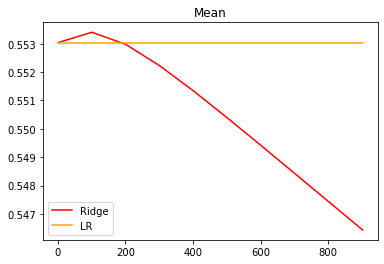

In [5]:
#交叉验证下，与线性回归相比，岭回归的结果如何变化？
alpharange = np.arange(1,1001,100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg,X,y,cv=5,scoring = 'r2').mean()
    linears = cross_val_score(linear,X,y,cv=5,scoring = 'r2').mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange,ridge,color='red',label='Ridge')
plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Mean')
plt.legend()
plt.show()

可以看出，加利佛尼亚数据集上，岭回归的结果轻微上升，随后骤降。可以说，加利佛尼亚房屋价值数据集带有很轻微的一部分共线性，这种共线性被正则化参数$α$消除后，模型的效果提升了一点点，但是对于整个模型而言是杯水车薪。在过了控制多重共线性的点后，模型的效果飞速下降，显然是正则化的程度太重，挤占了参数$w$本来的估计空间。从这个结果可以看出，加利佛尼亚数据集的核心问题不在于多重共线性，岭回归不能够提升模型表现。

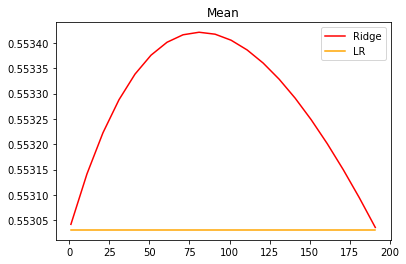

In [6]:
#细化一下学习曲线
alpharange = np.arange(1,201,10)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg,X,y,cv=5,scoring = 'r2').mean()
    linears = cross_val_score(linear,X,y,cv=5,scoring = 'r2').mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange,ridge,color='red',label='Ridge')
plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Mean')
plt.legend()
plt.show()

#### （2）方差

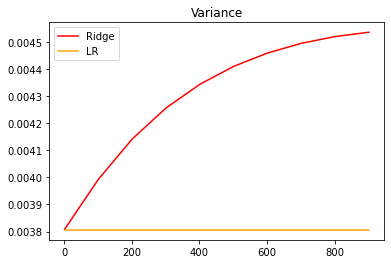

In [7]:
#模型方差如何变化？
alpharange = np.arange(1,1001,100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    varR = cross_val_score(reg,X,y,cv=5,scoring='r2').var()
    varLR = cross_val_score(linear,X,y,cv=5,scoring='r2').var()
    ridge.append(varR)
    lr.append(varLR)
plt.plot(alpharange,ridge,color='red',label='Ridge')
plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Variance')
plt.legend()
plt.show()

可以发现，模型的方差上升快速，不过方差的值本身很小，其变化不超过$R^2$上升部分的1/3，因此只要噪声的状况维持恒定，模型的泛化误差可能还是一定程度上降低了的。虽然岭回归和Lasso不是设计来提升模型表现，而是专注于解决多重共线性问题的，但当$α$在一定范围内变动的时候，消除多重共线性也许能够一定程度上提高模型的泛化能力。

### 6.波士顿房价数据集

In [8]:
from sklearn.datasets import load_boston
X = load_boston().data
y = load_boston().target
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)

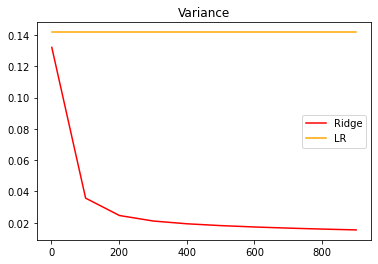

In [9]:
#先查看方差的变化
alpharange = np.arange(1,1001,100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    varR = cross_val_score(reg,X,y,cv=5,scoring='r2').var()
    varLR = cross_val_score(linear,X,y,cv=5,scoring='r2').var()
    ridge.append(varR)
    lr.append(varLR)
plt.plot(alpharange,ridge,color='red',label='Ridge')
plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Variance')
plt.legend()
plt.show()

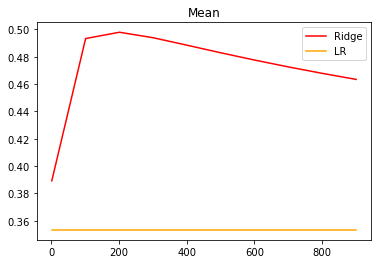

In [10]:
#查看R2的变化
alpharange = np.arange(1,1001,100)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    linear = LinearRegression()
    regs = cross_val_score(reg,X,y,cv=5,scoring = 'r2').mean()
    linears = cross_val_score(linear,X,y,cv=5,scoring = 'r2').mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange,ridge,color='red',label='Ridge')
plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Mean')
plt.legend()
plt.show()

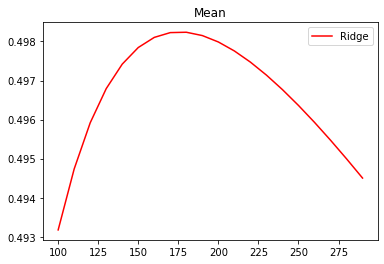

In [11]:
#细化学习曲线
alpharange = np.arange(100,300,10)
ridge, lr = [], []
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    #linear = LinearRegression()
    regs = cross_val_score(reg,X,y,cv=5,scoring = 'r2').mean()
    #linears = cross_val_score(linear,X,y,cv=5,scoring = 'r2').mean()
    ridge.append(regs)
    lr.append(linears)
plt.plot(alpharange,ridge,color='red',label='Ridge')
#plt.plot(alpharange,lr,color='orange',label='LR')
plt.title('Mean')
plt.legend()
plt.show()

可以发现，比起加利佛尼亚房屋价值数据集，波士顿房价数据集的方差降低明显，偏差也降低明显，可见使用岭回归还是起到了一定的作用，模型的泛化能力是有可能会上升的。<br>

## （三）选取最佳的正则化参数取值

### 1.岭寂图

岭寂图：以正则化参数为横坐标，线性模型求解的系数$w$为纵坐标，每一条线是一个系数$w$。岭迹图认为，线条交叉越多，则说明特征之间的多重共线性越高。我们应该选择系数较为平稳的喇叭口所对应的$α$取值作为最佳的正则化参数的取值。

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [13]:
#创造10*10的希尔伯特矩阵
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

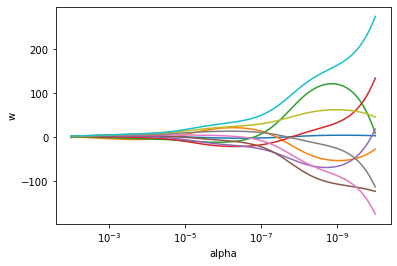

In [14]:
#计算横坐标
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
#建模，获取每一个正则化取值下的系数组合
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
#绘图展示结果
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])#将横坐标逆转
plt.xlabel('alpha')
plt.ylabel('w')
plt.axis('tight')
plt.show()

不建议使用岭迹图来作为寻找最佳参数的标准。<br>
1.岭迹图的很多细节，很难以解释。比如为什么多重共线性存在会使得线与线之间有很多交点？当$α$很大了之后看上去所有的系数都很接近于0，难道不是那时候线之间的交点最多吗？<br>
2.岭迹图的评判标准，非常模糊。哪里才是最佳的喇叭口？哪里才是所谓的系数开始变得“平稳”的时候？

### 2.带交叉验证的岭回归

`sklearn.linear_model.RidgeCV`(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)

重要参数|含义
:-|:-
alphas|需要测试的正则化参数的取值的元组
scoring|用来进行交叉验证的模型评估指标，默认是$R^2$，可自行调整
store_cv_values|是否保存每次交叉验证的结果，默认False
cv|交叉验证的模式，默认是None，表示默认进行**留一交叉验证**（一个样本作为测试集，其他样本作为训练集，有多少个样本就进行多少折交叉验证）<br>可以输入Kfold对象和StratifiedKFold对象来进行交叉验证<br>仅仅当为None时，每次交叉验证的结果才可以被保存下来<br>当cv有值存在（不是None）时，store_cv_values无法被设定为True
**重要属性**|**含义**
alpha_|查看交叉验证选中的alpha
cv_values_|调用所有交叉验证的结果，只有当store_cv_values=True的时候才能够调用，因此返回的结构是(n_samples, n_alphas)
**重要接口**|**含义**
score|调用Ridge类不进行交叉验证的情况下返回的$R^2$（方便对比）

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import train_test_split as TTS
from sklearn.datasets import fetch_california_housing as fch
import matplotlib.pyplot as plt

In [16]:
housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数","房屋使用年代中位数","平均房间数目" ,"平均卧室数目","街区人口","平均入住率","街区的纬度","街区的经度"]

In [17]:
Ridge_ = RidgeCV(alphas=np.arange(1,1001,100)
                 ,scoring='neg_mean_squared_error'
                 ,store_cv_values=True
                 #,cv=5
                ).fit(X, y)

In [18]:
#无关交叉验证的岭回归结果
Ridge_.score(X,y)

0.6060251767338429

In [19]:
#调用所有交叉验证的结果
Ridge_.cv_values_.shape #(20640个样本,10个alpha)

(20640, 10)

In [20]:
#进行平均后可以查看每个正则化系数取值下的交叉验证结果
Ridge_.cv_values_.mean(axis=0)

array([-6.10618033e-05, -9.07302179e-05, -1.11785961e-04, -1.27544011e-04,
       -1.39823410e-04, -1.49699514e-04, -1.57846229e-04, -1.64706208e-04,
       -1.70581703e-04, -1.75685916e-04])

In [21]:
#查看被选择出来的最佳正则化系数
Ridge_.alpha_

101

# 三、Lasso

## （一）Lasso解决多重共线性

Lasso全称最小绝对收缩和选择算子（least absolute shrinkage and selection operator），Lasso使用的是系数$w$的L1范式（L1范式则是系数$w$的绝对值）乘以正则化系数$α$，所以
Lasso的损失函数表达式为：

$$min_w||Xw-y||_{2}^{2}+α||w||_1$$

假设所有系数$w$都为正：

$$w=(X^TX)^{-1}X^Ty-\frac{αI}{2}$$

$X^TX$的逆必须存在.岭回归通过正则化系数$α$能够向方阵$X^TX$加上一个单位矩阵，以此来防止方阵$X^TX$的行列式为0，而现在L1范式所带的正则项$α$在求导之后并不带有$w$这个项，因此它无法对$X^TX$造成任何影响。也就是说，**Lasso无法解决特征之间“精确相关”的问题**。当使用最小二乘法求解线性回归时，如果线性回归无解或者报除零错误，换Lasso不能解决任何问题。

通过增大$α$，可以为$w$的计算增加一个负项，从而限制参数估计中$w$的大小，而防止多重共线性引起的参数$w$被估计过大导致模型失准的问题。**Lasso不是从根本上解决多重共线性问题，而是限制多重共线性带来的影响**。

假设系数$w$无法为正，则很有可能需要将正则项参数$α$设定为负，因此$α$可以取负数，并且负数越大，对共线性的限制也越大。

所有这些让Lasso成为了一个神奇的算法，尽管它是为了限制多重共线性被创造出来的，然而世人其实并不使用它来抑制多重共线性，反而接受了它在其他方面的优势。在讲解逻辑回归时曾提到过，L1和L2正则化一个核心差异就是他们对系数$w$的影响：两个正则化都会压缩系数$w$的大小，**对标签贡献更少的特征的系数会更小**，也会更容易被压缩。不过，L2正则化只会将系数压缩到尽量**接近0**，但L1正则化主导稀疏性，因此会将系数压缩到**0**。这个性质，让Lasso成为了线性模型中的特征选择工具首选。

## （二）Lasso的核心作用：特征选择

`sklearn.linear_model.Lasso`(**alpha=1.0**, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, **positive=False**, random_state=None, selection='cyclic')

当参数positive为'True'时，是要求Lasso回归出的系数必须为正数，以此来保证$α$一定以增大来控制正则化的程度。

sklearn中Lasso的损失函数：（消除对损失函数求导后多出来的2）

$$min_w\frac{1}{2n_{samples}}||Xw-y||_{2}^{2}+α||w||_1$$

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split as TTS
from sklearn.datasets import fetch_california_housing as fch #加利福尼亚房屋价值
import matplotlib.pyplot as plt

In [23]:
housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target
X.columns = ["住户收入中位数","房屋使用年代中位数","平均房间数目","平均卧室数目","街区人口","平均入住率","街区的纬度","街区的经度"]
X.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [24]:
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)
#恢复索引
for i in [Xtrain,Xtest]:
    i.index = range(i.shape[0])

In [25]:
#线性回归进行拟合
reg = LinearRegression().fit(Xtrain,Ytrain)
(reg.coef_*100).tolist()

[43.73589305968403,
 1.0211268294494038,
 -10.780721617317715,
 62.64338275363783,
 5.216125353178735e-05,
 -0.33485096463336095,
 -41.30959378947711,
 -42.621095362084674]

In [26]:
#岭回归进行拟合
Ridge_ = Ridge(alpha=0).fit(Xtrain,Ytrain)
(Ridge_.coef_*100).tolist()

[43.735893059684045,
 1.0211268294494151,
 -10.780721617317626,
 62.64338275363741,
 5.2161253532713044e-05,
 -0.3348509646333588,
 -41.3095937894767,
 -42.62109536208427]

In [27]:
#Lasso进行拟合
lasso_ = Lasso(alpha=0).fit(Xtrain,Ytrain)
(lasso_.coef_*100).tolist()

<ipython-input-27-76c577e38589>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_ = Lasso(alpha=0).fit(Xtrain,Ytrain)
D:\22Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\22Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3769.8607714139102, tolerance: 1.917255476913148
  model = cd_fast.enet_coordinate_descent(


[43.735893059684024,
 1.0211268294494056,
 -10.78072161731769,
 62.64338275363792,
 5.2161253532654165e-05,
 -0.33485096463335706,
 -41.3095937894772,
 -42.62109536208478]

sklearn中的Lasso类不是使用最小二乘法来进行求解，而是使用坐标下降。有了坐标下降，就有迭代和收敛的问题，因此sklearn不推荐使用0这样的正则化系数。如果的确希望取到0，那可以使用一个比较很小的数，比如0.01或者更小：

In [28]:
#岭回归进行拟合
Ridge_ = Ridge(alpha=0.01).fit(Xtrain,Ytrain)
(Ridge_.coef_*100).tolist()

[43.73575720621605,
 1.0211292318121836,
 -10.780460336251702,
 62.64202320775686,
 5.217068073243689e-05,
 -0.3348506517067627,
 -41.3095714322911,
 -42.62105388932374]

In [29]:
#Lasso进行拟合
lasso_ = Lasso(alpha=0.01).fit(Xtrain,Ytrain)
(lasso_.coef_*100).tolist()

[40.10568371834486,
 1.0936292607860143,
 -3.7423763610244487,
 26.524037834897207,
 0.0003525368511503945,
 -0.3207129394887799,
 -40.06483047344844,
 -40.81754399163315]

Lasso对$α$更加敏感。加大正则项系数，观察模型的系数发生了什么变化：

In [30]:
Ridge_ = Ridge(alpha=10**4).fit(Xtrain,Ytrain)
(Ridge_.coef_*100).tolist()

[34.620815176076945,
 1.5196170869238694,
 0.3968610529210133,
 0.9151812510354866,
 0.002173923801224843,
 -0.34768660148101016,
 -14.736963474215257,
 -13.43557610252691]

In [31]:
lasso_ = Lasso(alpha=10**4).fit(Xtrain,Ytrain)
(lasso_.coef_*100).tolist()

[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0]

In [32]:
#看来10**4对于Lasso来说是一个过于大的取值
lasso_ = Lasso(alpha=1).fit(Xtrain,Ytrain)
(lasso_.coef_*100).tolist()

[14.581141247629423,
 0.6209347344423876,
 0.0,
 -0.0,
 -0.00028065986329009983,
 -0.0,
 -0.0,
 -0.0]

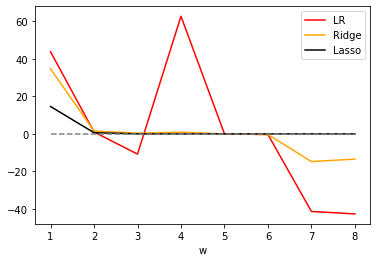

In [33]:
#将系数进行绘图
plt.plot(range(1,9),(reg.coef_*100).tolist(),color='red',label='LR')
plt.plot(range(1,9),(Ridge_.coef_*100).tolist(),color='orange',label='Ridge') #alpha=10000
plt.plot(range(1,9),(lasso_.coef_*100).tolist(),color='k',label='Lasso') #alpha=1
plt.plot(range(1,9),[0]*8,color='grey',linestyle='--')
plt.xlabel('w') #横坐标是每一个特征所对应的系数
plt.legend()
plt.show()

可见，比起岭回归，Lasso所带的L1正则项对于系数的惩罚要重得多，并且它会将系数压缩至0，因此可以被用来做特征选择。也因此往往让Lasso的正则化系数$α$在很小的空间中变动，以此来寻找最佳的正则化系数。

## （三）选取最佳的正则化参数取值

`sklearn.linear_model.LassoCV`(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv='warn', verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')

参数|含义
:-|:-
eps|正则化路径的长度，默认0.001。
n_alphas|正则化路径中的个数，默认100。
alphas|需要测试的正则化参数的取值的元祖，默认None。当不输入的时候，自动使用eps和n_alphas来自动生成带入交叉验证的正则化参数。
cv|交叉验证的次数，默认5折交叉验证。

由于Lasso对正则化系数的变动过于敏感，因此往往让$α$在很小的空间中变动。这个小空间小到超乎人们的想象（不是0.01到0.02之间这样的空间，这个空间对lasso而言还是太大了），因此设定了一个重要概念“正则化路径”，用来设定正则化系数的变动。假设特征矩阵中有$n$个特征，则我们就有特征向量$x_1, x_2, ...,x_n$。对于每一个$α$的取值，都可以得出一组对应这个特征向量的参数向量$w$，其中包含了n+1个参数，分别是$w_1, w_2, ...,w_n$。这些参数可以被看作是一个n+1维空间中的一个点。对于不同的$α$取值，就将得到许多个在n+1维空间中的点，所有的这些点形成的序列，就被称为**正则化路径**。形成这个正则化路径的$α$的最小值除以$α$的最大值得到的量称为**正则化路径的长度**（length of the path）。

属性|含义
:-|:-
alpha_|调用交叉验证选出来的最佳正则化参数。
alphas_|使用正则化路径的长度和路径中$α$的个数来自动生成的，用来进行交叉验证的正则化参数。
mse_path|返回所以交叉验证的结果细节。
coef_|调用最佳正则化参数下建立的模型的系数。

In [34]:
from sklearn.linear_model import LassoCV

### 1.自己建立Lasso进行alpha选择的范围

In [35]:
alpharange = np.logspace(-10, -2, 200, base=10)#10^(-10)到10^(-2)次方
alpharange.shape

(200,)

In [36]:
Xtrain.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,4.1776,35.0,4.425172,1.030683,5380.0,3.368817,37.48,-122.19
1,5.3261,38.0,6.267516,1.089172,429.0,2.732484,37.53,-122.30
2,1.9439,26.0,5.768977,1.141914,891.0,2.940594,36.02,-119.08
3,2.5000,22.0,4.916000,1.012000,733.0,2.932000,38.57,-121.31
4,3.8250,34.0,5.036765,1.098039,1134.0,2.779412,33.91,-118.35


In [37]:
lasso_ = LassoCV(alphas=alpharange #自行输入的alpha的取值范围
                ,cv=5 #交叉验证的折数
                ).fit(Xtrain, Ytrain)

In [38]:
#查看被选择出来的最佳正则化系数
lasso_.alpha_

0.0020729217795953697

In [39]:
#调用所有交叉验证的结果
lasso_.mse_path_

array([[0.52454913, 0.49856261, 0.55984312, 0.50526576, 0.55262557],
       [0.52361933, 0.49748809, 0.55887637, 0.50429373, 0.55283734],
       [0.52281927, 0.49655113, 0.55803797, 0.5034594 , 0.55320522],
       [0.52213811, 0.49574741, 0.55731858, 0.50274517, 0.55367515],
       [0.52155715, 0.49505688, 0.55669995, 0.50213252, 0.55421553],
       [0.52106069, 0.49446226, 0.55616707, 0.50160604, 0.55480104],
       [0.5206358 , 0.49394903, 0.55570702, 0.50115266, 0.55541214],
       [0.52027135, 0.49350539, 0.55530895, 0.50076146, 0.55603333],
       [0.51995825, 0.49312085, 0.5549639 , 0.50042318, 0.55665306],
       [0.5196886 , 0.49278705, 0.55466406, 0.50013007, 0.55726225],
       [0.51945602, 0.49249647, 0.55440306, 0.49987554, 0.55785451],
       [0.51925489, 0.49224316, 0.55417527, 0.49965404, 0.55842496],
       [0.51908068, 0.49202169, 0.55397615, 0.49946088, 0.55897049],
       [0.51892938, 0.49182782, 0.55380162, 0.49929206, 0.55948886],
       [0.51879778, 0.49165759, 0.

In [40]:
#返回每个alpha下的五折交叉验证结果
lasso_.mse_path_.shape

(200, 5)

In [41]:
#有注意到在岭回归中的轴向是axis=0吗？
lasso_.mse_path_.mean(axis=1)

array([0.52816924, 0.52742297, 0.5268146 , 0.52632488, 0.52593241,
       0.52561942, 0.52537133, 0.5251761 , 0.52502385, 0.52490641,
       0.52481712, 0.52475046, 0.52470198, 0.52466795, 0.52464541,
       0.52463188, 0.5246254 , 0.52462436, 0.52462744, 0.52463361,
       0.52464201, 0.52465199, 0.52466301, 0.52467466, 0.5246866 ,
       0.5246986 , 0.52471046, 0.52472203, 0.5247332 , 0.52474392,
       0.52475413, 0.52476379, 0.52477291, 0.52478147, 0.52478949,
       0.52479697, 0.52480393, 0.52481039, 0.52481639, 0.52482193,
       0.52482706, 0.52483179, 0.52483615, 0.52484016, 0.52484385,
       0.52484725, 0.52485036, 0.52485322, 0.52485584, 0.52485824,
       0.52486044, 0.52486246, 0.5248643 , 0.52486599, 0.52486753,
       0.52486895, 0.52487024, 0.52487141, 0.52487249, 0.52487348,
       0.52487437, 0.52487519, 0.52487594, 0.52487663, 0.52487725,
       0.52487782, 0.52487834, 0.52487882, 0.52487925, 0.52487965,
       0.52488001, 0.52488033, 0.52488063, 0.52488091, 0.52488

岭回归是留一验证，因此交叉验证结果返回的是，每一个样本在每个alpha下的交叉验证结果，因此要求每个alpha下的交叉验证均值，就是axis=0，跨行求均值。而在这里返回的是每一个alpha取值下每一折交叉验证的结果，因此要求每个alpha下的交叉验证均值，就是axis=1，跨列求均值。

In [42]:
#最佳正则化系数下获得的模型的系数结果
lasso_.coef_

array([ 4.29867301e-01,  1.03623683e-02, -9.32648616e-02,  5.51755252e-01,
        1.14732262e-06, -3.31941716e-03, -4.10451223e-01, -4.22410330e-01])

In [43]:
lasso_.score(Xtest,Ytest)

0.6038982670571436

In [44]:
#与线性回归相比如何？
reg = LinearRegression().fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)

0.6043668160178817

线性回归略胜一筹。

### 2.使用lassoCV自带的正则化路径长度和路径中的alpha个数自动建立alpha选择的范围

In [45]:
ls_ = LassoCV(eps=0.00001
             ,n_alphas=300
             ,cv=5
             ).fit(Xtrain, Ytrain)

In [46]:
#调用交叉验证选出来的最佳正则化参数
ls_.alpha_

0.0020954551690628557

与自己建立Lasso进行alpha选择的范围的方式得到的最佳正则化参数非常接近。

In [47]:
#查看所有自动生成的alpha取值
ls_.alphas_

array([2.94059737e+01, 2.82952253e+01, 2.72264331e+01, 2.61980122e+01,
       2.52084378e+01, 2.42562424e+01, 2.33400142e+01, 2.24583946e+01,
       2.16100763e+01, 2.07938014e+01, 2.00083596e+01, 1.92525862e+01,
       1.85253605e+01, 1.78256042e+01, 1.71522798e+01, 1.65043887e+01,
       1.58809704e+01, 1.52811004e+01, 1.47038891e+01, 1.41484809e+01,
       1.36140520e+01, 1.30998100e+01, 1.26049924e+01, 1.21288655e+01,
       1.16707233e+01, 1.12298864e+01, 1.08057012e+01, 1.03975388e+01,
       1.00047937e+01, 9.62688384e+00, 9.26324869e+00, 8.91334908e+00,
       8.57666619e+00, 8.25270079e+00, 7.94097249e+00, 7.64101907e+00,
       7.35239575e+00, 7.07467457e+00, 6.80744372e+00, 6.55030695e+00,
       6.30288297e+00, 6.06480491e+00, 5.83571975e+00, 5.61528779e+00,
       5.40318218e+00, 5.19908842e+00, 5.00270386e+00, 4.81373731e+00,
       4.63190858e+00, 4.45694804e+00, 4.28859627e+00, 4.12660362e+00,
       3.97072991e+00, 3.82074399e+00, 3.67642348e+00, 3.53755437e+00,
      

In [48]:
ls_.alphas_.shape #参数n_alphas=300

(300,)

In [49]:
ls_.score(Xtest,Ytest)

0.60389154238192

In [50]:
#系数
ls_.coef_

array([ 4.29785372e-01,  1.03639989e-02, -9.31060823e-02,  5.50940621e-01,
        1.15407943e-06, -3.31909776e-03, -4.10423420e-01, -4.22369926e-01])

现实中不仅可以使用交叉验证来选择最佳正则化系数，也可以使用**BIC**（贝叶斯信息准则）或**AIC**（Akaike information criterion，艾凯克信息准则）来做模型选择。同时也可以不使用坐标下降法，而使用最小角度回归来对lasso进行计算。这些方法下做的模型选择和模型计算，其实在模型效果上表现和普通的Lasso没有太大的区别，但他们都在各个方面对原有的Lasso做了一些相应的改进（比如说提升了本来就已经很快的计算速度，增加了模型选择的维度，因为均方误差作为损失函数只考虑了偏差，不考虑方差的存在）。